# Solving Partial Differential Equations with Neural Networks

##### Authors: Szymon Malec (262276) & Damian Szuster (262229)

## 1. Introduction

Partial differential equations (PDE) appear in numerous fields of science i.a. in mathematics, physics or chemistry. Their task is to describe change of some quantities by using derivatives of given function. Unfortunately, most of them do not have analytical solution. Thus, lots of numerical methods have been derived. One of them, perhaps less known, is solving PDEs with a help of neural networks. That is the main topic of our report.

## 2. Neural networks

#### 2.1. Introduction to Neural Networks

Neural networks, inspired by the biological neural networks of the human brain, are a subset of machine learning techniques designed to recognize patterns. They consist of interconnected layers of nodes (or neurons) that process data and learn to make predictions or decisions without explicit programming.

#### 2.2. Basic Structure of Neural Networks

A neural network typically consists of an input layer, one or more hidden layers, and an output layer:

- **Input Layer:** This layer receives the raw input data. Each neuron in the input layer represents a feature of the input data.
- **Hidden Layers:** These intermediate layers transform the input into something the output layer can use. They apply weights to the inputs and pass the results through activation functions to capture non-linear relationships.
- **Output Layer:** This layer produces the final output, which can be a single value or a vector of values, depending on the problem.

#### 2.3. Training Neural Networks

The process of training a neural network involves the following steps:

1. **Forward Propagation:** Input data is passed through the network, layer by layer, until an output is generated.
2. **Loss Calculation:** The difference between the predicted output and the actual target is quantified using a loss function.
3. **Backward Propagation:** The network adjusts the weights of the connections to minimize the loss. This is done using algorithms such as gradient descent, which calculates the gradient of the loss function with respect to each weight.
4. **Iteration:** The process is repeated for many iterations, gradually improving the accuracy of the network.

#### 2.4. Activation Functions

Activation functions introduce non-linearity into the network, allowing it to model complex relationships. Common activation functions include:

- **Sigmoid:** Outputs values between 0 and 1, used for binary classification.
- **ReLU (Rectified Linear Unit):** Outputs the input directly if positive; otherwise, it outputs zero. This function helps to mitigate the vanishing gradient problem.
- **Tanh:** Outputs values between -1 and 1, used for centering data.

#### 2.5. Neural Networks for Solving PDEs

Partial differential equations (PDEs) are equations that involve rates of change with respect to continuous variables. Solving PDEs is crucial in various fields such as physics, engineering, and finance. Traditional methods for solving PDEs, such as finite element methods, can be computationally intensive.

Neural networks provide an alternative approach to solving PDEs through the following methods:

- **Physics-Informed Neural Networks (PINNs):** These networks incorporate physical laws described by PDEs into the loss function. The network is trained not only on data but also on the underlying physical principles, ensuring that the solution respects the PDE.
- **Deep Galerkin Method (DGM):** This method approximates the solution to PDEs using deep neural networks. It leverages the universal approximation capability of neural networks to represent complex solutions.

In this report we use the first approach which is Physics-Informed Neural Network.

#### 2.6. Advantages of Neural Networks for PDEs

- **Flexibility:** Neural networks can approximate complex functions and handle high-dimensional problems that are challenging for traditional methods.
- **Data Efficiency:** PINNs and similar approaches can leverage available data more effectively by incorporating physical laws into the learning process.
- **Parallelization:** Neural network training can be parallelized, taking advantage of modern high-performance computing resources.

#### 2.7. Disadvantages

Despite their advantages, neural networks for PDEs face several challenges:

- **Training Complexity:** Training neural networks to solve PDEs can be computationally expensive and requires careful tuning of hyperparameters.
- **Generalization:** Ensuring that the network generalizes well to unseen data and different boundary conditions is a significant challenge.
- **Interpretability:** Neural network models are often seen as black boxes, making it difficult to interpret the solution process.


## 3. Implementation

For the implementation we used Python programming language. Some of python packages turned out to be very useful, especially well-known `numpy` library but also `autograd` which provides functions for numerical gradient calculation. Therefore, let's import necessary packages.

In [1]:
import numpy
import autograd.numpy as np
from autograd import grad, elementwise_grad
from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D

Firstly, we define two activation functions, which we'll use in neural networks. These are ReLu and sigmoid.

In [2]:
def relu(x):
    return np.maximum(x, 0)

def sigmoid(x):
    return 1/(1 + np.exp(-x))

Next, let's create the function which returns the output of the neural network. The function below calculates values in all neurons layer by layer ending with the output layer. It needs weights of the network to be specified and passed as numpy arrays.

In [3]:
def neural_network(x, weights, activation_function=sigmoid):
    for W in weights[:-1]:
        x = np.vstack([np.ones(x.shape[1]), x])
        x = activation_function(W @ x)
    x = np.vstack([np.ones(x.shape[1]), x])
    x = weights[-1] @ x
    return x

An inherent element of neural network is the cost (loss) function, which should be minimized through the training process. The right choice of the cost is an important step. In case of Physical Informed Neural Networks the cost function is assumed to be the square of the differential equation. Notice that, if we put all the elements on one side of the equation, we can represent the equation as
$$
f\left(g, x_1, \, \dots \, , x_N, \frac{\partial g}{\partial x_1}, \dots , \frac{\partial g}{\partial x_N}, \frac{\partial g}{\partial x_1\partial x_2}, \, \dots \, , \frac{\partial^n }{\partial x_N^n} \right) = 0
$$
for the function $g = g(x_1,\dots,x_N)$ of $N$ variables. We may treat the above as an error. Thus the cost function can be expressed as
$$ C(x, W) = f^2. $$

In [4]:
def cost(X, g_t, equation, weights):
    return np.mean(equation(X, g_t, weights)**2)

And finally the function which solves the equation.

In [5]:
def solve(equation, g_t, X, layers, epochs, learning_rate=0.001):

    cost_grad = elementwise_grad(cost, 3)
    weights = [np.random.randn(layers[layer + 1], layers[layer] + 1) for layer in range(len(layers) - 1)]

    for epoch in range(epochs):
        dW = cost_grad(X, g_t, equation, weights)
        for w in range(len(weights)):
            weights[w] -= learning_rate * dW[w]
    return weights

## 4. Example
Now let's use our functions in an example. For the visualisation we will use some helpful functions.

In [6]:
def plot2D(xs, nn_solution, analytical_solution):
    print('Max absolute difference:', np.max(np.abs(nn_solution - analytical_solution)))
    plt.figure(figsize=(6, 6))
    plt.plot(xs.flatten(), analytical_solution.flatten(), label='Analytical')
    plt.plot(xs.flatten(), nn_solution.flatten(), label='Neural network')
    plt.legend()
    plt.xlabel('x')
    plt.ylabel('g(x)')
    plt.show()

def plot3D(ts, xs, nn_solution, analytical_solution):
    print('Max absolute difference:', np.max(np.abs(nn_solution - analytical_solution)))
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, subplot_kw={"projection": "3d"}, figsize=(14, 6))
    ax1.plot_surface(ts, xs, analytical_solution)
    ax1.set(title='Analytical solution')
    ax2.plot_surface(ts, xs, nn_solution)
    ax2.set(title='Neural network')
    ax3.plot_surface(ts, xs, nn_solution - analytical_solution)
    ax3.set(title='Difference')
    plt.show()

#### 4.1. Parameters
There are three hyperparameters in neural networks: number of hidden layers, number of neurons in each layer and activation functions. Choice of these hyperparameters should differ depending on analyzed situation.

#### 4.2. Wave equation

To check the quality of our model we have chosen wave equation. It is a second-order linear PDE applied to model wavelike phenomena, e.g. small-amplitude oscilations near equilibrium. In this project we will consider the wave equation in one space dimension:

$$
\frac{\partial^{2}g}{\partial t^{2}} = c^{2}\frac{\partial^{2}g}{\partial x^{2}},
$$

where $c$ is wave speed. In our example we assume $c = 1$. Additionally, some initial conditions are given:

$$
g(x,0)=\phi(x),
$$
$$
g_{t}(x,0)=\psi(x).
$$

It is also possible in many ways to describe other boundary conditions. In our case we will use Dirichlet condition. It describes how endpoints of our wave move:

$$
g(0,t) = \mu(t),
$$

$$
g(N,t) = \nu(t).
$$

We say that endpoints are fixed when $\mu = \nu = 0.$

For this example we will use one hidden layer with 100 neurons and the ReLu activation function. The network is trained on 100 equidistant points placed on $[0, 1]\times [0, 1]$ square. The cost function is average of 100 squared errors calculated in those points. Each epoch includes one cost calculation and bacpropagation. The following network is trained in 1000 epochs.

Max absolute difference: 0.16846140940448007


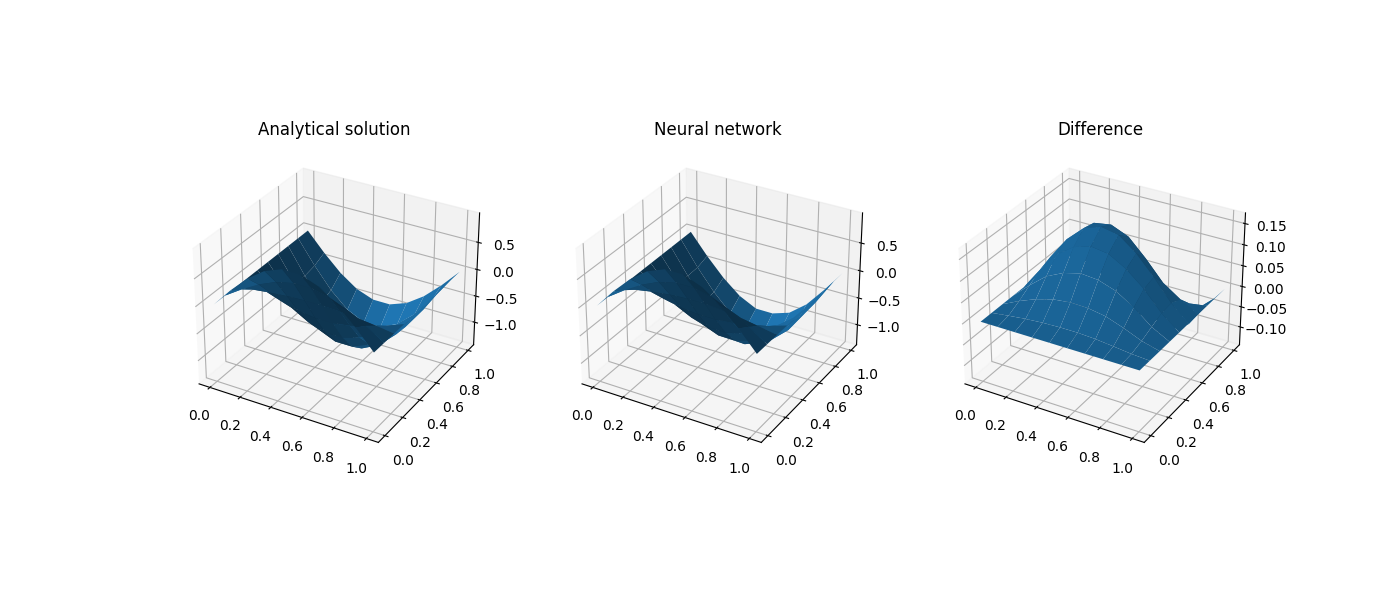

In [7]:
%matplotlib widget

def g_analytic(t, x):
    return np.sin(np.pi * x) * np.cos(np.pi * t) - np.sin(np.pi * x) * np.sin(np.pi * t)

def g_trial(t, x, weights):
    X = np.vstack((t, x))
    return (1 - t**2) * np.sin(np.pi * x) - t * np.pi * np.sin(np.pi * x) + x * (1 - x) * t**2 * neural_network(X, weights, relu)

def equation(X, g, weights):
    t = X[0,:]
    x = X[1,:]
    g_t = elementwise_grad(g, 0)
    g_tt = elementwise_grad(g_t, 0)
    g_x = elementwise_grad(g, 1)
    g_xx = elementwise_grad(g_x, 1)
    return g_tt(t, x, weights) - g_xx(t, x, weights)


ts = np.linspace(0, 1, 10)
xs = np.linspace(0, 1, 10)
ts, xs = np.meshgrid(ts, xs)
X = np.vstack([xs.ravel(), ts.ravel()])

layers = [2, 100, 1]
epochs = 1000
weights = solve(equation, g_trial, X, layers, epochs)
nn_solution = g_trial(X[0,:], X[1,:], weights).reshape(10, 10)
analytical_solution = g_analytic(X[0,:], X[1,:]).reshape(10, 10)

plot3D(ts, xs, nn_solution, analytical_solution)

## 5. Convergence

To examine the convergence of the method we have to slightly modify the solve function.

In [8]:
def solve(equation, g_t, X, layers, epochs, learning_rate=0.001):
    cost_grad = elementwise_grad(cost, 3)
    weights = [np.random.randn(layers[layer + 1], layers[layer] + 1) for layer in range(len(layers) - 1)]
    cost_history = []
    for epoch in range(epochs):
        dW = cost_grad(X, g_t, equation, weights)
        for w in range(len(weights)):
            weights[w] -= learning_rate * dW[w]
        if epoch % 10 == 0:
            current_cost = cost(X, g_t, equation, weights)
            cost_history.append(current_cost)
            print(f'Epoch {epoch}, Cost: {current_cost}')
    return weights, cost_history

And now we can run test for convergence.

Epoch 0, Cost: 52.47044885165947
Epoch 10, Cost: 6.229617526815827
Epoch 20, Cost: 5.044286236560655
Epoch 30, Cost: 4.879321822463797
Epoch 40, Cost: 4.653004427168677
Epoch 50, Cost: 4.535837918949464
Epoch 60, Cost: 4.224926663669118
Epoch 70, Cost: 4.077430219876191
Epoch 80, Cost: 4.0119166049390005
Epoch 90, Cost: 3.8831449201270254


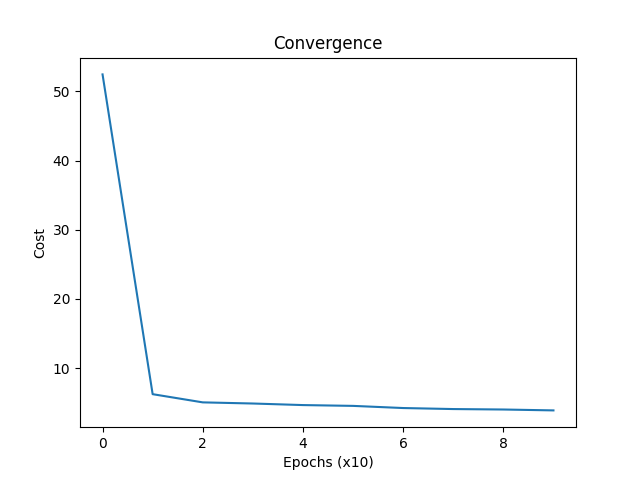

In [9]:
ts = np.linspace(0, 1, 10)
xs = np.linspace(0, 1, 10)
ts, xs = np.meshgrid(ts, xs)
X = np.vstack([xs.ravel(), ts.ravel()])

layers = [2, 100, 1]
epochs = 100
weights, cost_history = solve(equation, g_trial, X, layers, epochs)

plt.figure()
plt.plot(cost_history)
plt.xlabel('Epochs (x10)')
plt.ylabel('Cost')
plt.title('Convergence')
plt.show()

As we can see, the method is convergent.

## 6. Conclusion

In this project, we examined how neural networks can be used to solve partial differential equations (PDEs). Neural networks, particularly Physics-Informed Neural Networks (PINNs), offer a flexible and efficient alternative to traditional numerical methods by incorporating physical laws into the learning process.

While neural networks provide significant advantages in terms of flexibility and data efficiency, they also present challenges such as training complexity, hyperparameter tuning, and generalization to new data. Addressing these issues requires continued research in training algorithms.

Despite these challenges, the potential of neural networks in solving complex PDEs is immense. With advancements in computational power and algorithm development, neural networks have a potential to become crucial tools in scientific and engineering fields, driving future innovations and solutions.

## 7. Bibliography

[1] Honchar, A. "Neural networks for solving differential equations [WWW Document]." Becom. Hum. Artif. Intell. Mag. URL https://becominghuman.ai/neural-networks-for-solving-differential-equations-fa230ac5e04c (accessed 4.22. 19) (2017).

[2] Blechschmidt, Jan, and Oliver G. Ernst. "Three ways to solve partial differential equations with neural networks—A review." GAMM‐Mitteilungen 44.2 (2021): e202100006.

[3] Chiaramonte, M., and M. Kiener. "Solving differential equations using neural networks." Machine Learning Project 1 (2013).